<h1> HW3 </h1>

## 1.a

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as T
import keras
from keras import backend as K
from keras import initializers
from keras.initializers import RandomNormal
from keras.models import Sequential, Model, load_model, save_model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, merge, Reshape, Merge, Flatten
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from keras.regularizers import l2
from keras.layers import Multiply, Concatenate
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from time import time
import multiprocessing as mp
import sys
import math
import argparse
import matplotlib.pyplot as plt

Using TensorFlow backend.


Define dataset folder and files

In [32]:
MOVIELENS_DIR = 'ml-100k/'
RATING_DATA_FILE = 'u1.base'
RATINGS_CSV_FILE = 'u1_emb.data'
MODEL_WEIGHTS_FILE = 'u1_emb_weights.h5'

The user and item id for embedding should start from 0.
Update ids and save to file

In [33]:
ratings = pd.read_csv(os.path.join(MOVIELENS_DIR, RATING_DATA_FILE), 
                    sep='\t', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'movieid', 'rating', 'timestamp'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
ratings['user_emb_id'] = ratings['userid'] - 1
ratings['movie_emb_id'] = ratings['movieid'] - 1
print(str(len(ratings))+' ratings loaded')
ratings.to_csv(RATINGS_CSV_FILE, 
               sep='\t', 
               header=True, 
               encoding='latin-1', 
               columns=['userid', 'movieid', 'rating', 'timestamp', 'user_emb_id', 'movie_emb_id'])
print('Saved to '+RATINGS_CSV_FILE)

80000 ratings loaded
Saved to u1_emb.data


Load train rating file

In [34]:
ratings = pd.read_csv(RATINGS_CSV_FILE, 
                      sep='\t', 
                      encoding='latin-1', 
                      usecols=['userid', 'movieid', 'user_emb_id', 'movie_emb_id', 'rating'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
print(str(len(ratings)), 'ratings loaded.')
print('users '+str(max_userid)+' items '+str(max_movieid))

80000 ratings loaded.
users 943 items 1682


In [35]:
print(ratings)

       userid  movieid  rating  user_emb_id  movie_emb_id
0           1        1       5            0             0
1           1        2       3            0             1
2           1        3       4            0             2
3           1        4       3            0             3
4           1        5       3            0             4
5           1        7       4            0             6
6           1        8       1            0             7
7           1        9       5            0             8
8           1       11       2            0            10
9           1       13       5            0            12
10          1       15       5            0            14
11          1       16       5            0            15
12          1       18       4            0            17
13          1       19       5            0            18
14          1       21       1            0            20
15          1       22       4            0            21
16          1 

Prepare inputs to model

In [36]:
shuffled_ratings = ratings.sample(frac=1.)
Users = shuffled_ratings['user_emb_id'].values
Movies = shuffled_ratings['movie_emb_id'].values
Ratings = shuffled_ratings['rating'].values

In [37]:
shuffled_ratings

,userid,movieid,rating,user_emb_id,movie_emb_id
65705,804,97,4,803,96
29050,435,264,3,434,263
221,5,63,1,4,62
45730,592,988,1,591,987
19032,325,186,4,324,185
41612,545,202,4,544,201
48574,625,183,3,624,182
39053,526,748,1,525,747
49453,635,1,4,634,0
70569,854,1011,2,853,1010


Define matrix factorization model

In [38]:
def get_model(num_users, num_items, latent_dim):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings
    prediction = merge([user_latent, item_latent], mode = 'dot')
    
    
    model = Model(input=[user_input, item_input], output=prediction)

    return model


Define embedding size and compile model

In [39]:
K_LATENT = 20
MF_model = get_model(max_userid,max_movieid,K_LATENT)
MF_model.compile(loss='mse', optimizer='adamax',metrics=['mae'])

C:\Users\qvkg67\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
C:\Users\qvkg67\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\legacy\layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\qvkg67\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("me...)`


## 1.b

Train model

In [40]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
history = MF_model.fit([Users, Movies], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

Train on 64000 samples, validate on 16000 samples
Epoch 1/12
64000/64000 [==============================] - 6s 99us/step - loss: 13.6942 - mean_absolute_error: 3.5280 - val_loss: 13.5644 - val_mean_absolute_error: 3.5080
Epoch 2/12
64000/64000 [==============================] - 6s 90us/step - loss: 13.0940 - mean_absolute_error: 3.4444 - val_loss: 12.1973 - val_mean_absolute_error: 3.3125
Epoch 3/12
64000/64000 [==============================] - 6s 98us/step - loss: 10.6412 - mean_absolute_error: 3.0608 - val_loss: 8.9009 - val_mean_absolute_error: 2.7466
Epoch 4/12
64000/64000 [==============================] - 5s 77us/step - loss: 7.1296 - mean_absolute_error: 2.3737 - val_loss: 5.8157 - val_mean_absolute_error: 2.0745
Epoch 5/12
64000/64000 [==============================] - 6s 89us/step - loss: 4.7945 - mean_absolute_error: 1.8314 - val_loss: 4.1667 - val_mean_absolute_error: 1.6763
Epoch 6/12
64000/64000 [==============================] - 6s 92us/step - loss: 3.5304 - mean_absolut

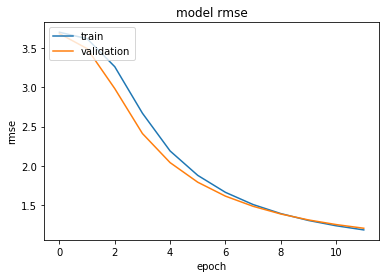

In [41]:
loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})

plt.plot(loss['training'])
plt.plot(loss['validation'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()